# Blood Donations

## Preamble

In [1]:
%matplotlib inline

In [2]:
ls

Blood Donations.ipynb              BloodDonations-Training.csv
BloodDonationSubmissionFormat.csv  submission.csv
BloodDonations-Test.csv            transfusion.data


In [3]:
import pandas
import seaborn
import matplotlib.pyplot as plt
import numpy

In [4]:
seaborn.set_style("whitegrid")

## Getting the Data

In [5]:
trainingData = pandas.read_csv("BloodDonations-Training.csv", index_col=0)
testData = pandas.read_csv("BloodDonations-Test.csv", index_col=0)

In [6]:
testData.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4
303,11,11,2750,38
83,4,12,3000,34


## First Exploration

In [7]:
trainingData.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [8]:
trainingData.describe()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


/usr/local/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


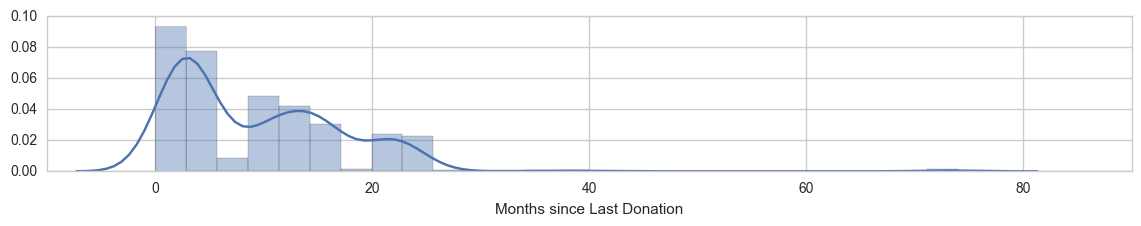

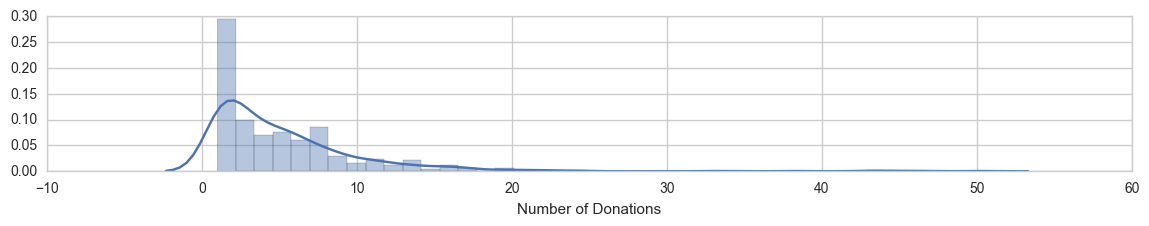

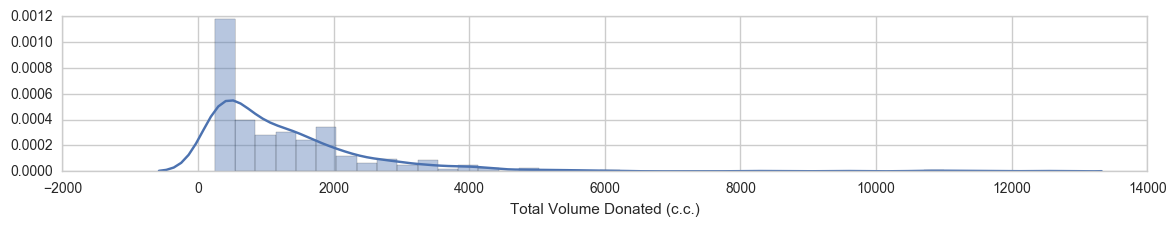

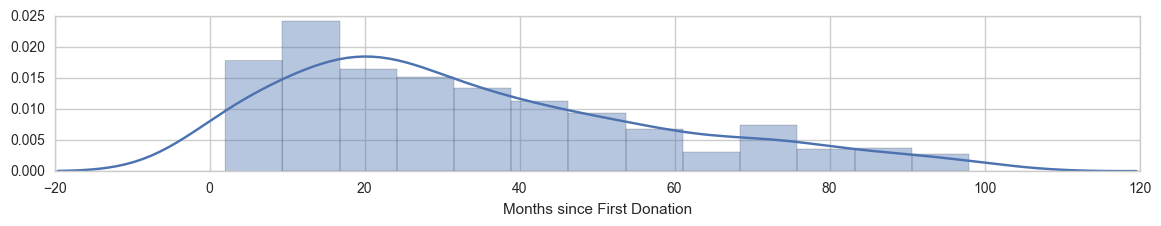

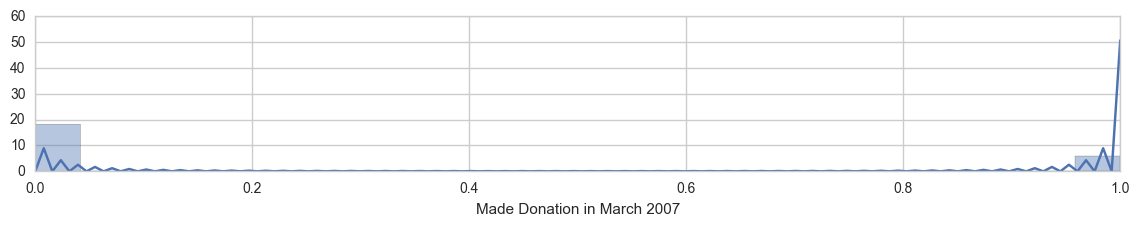

In [9]:
for column in trainingData.columns:
    plt.figure(figsize=(14,2))
    seaborn.distplot(trainingData[column])

## Model Selection

### Possible Models

In [10]:
from sklearn import ensemble, svm, linear_model, tree, neural_network, base, neighbors, naive_bayes
import xgboost

In [11]:
# {"model name" -> (class, params)}
modelTypes = {
    "Decision Tree": (tree.DecisionTreeClassifier, {"random_state": 42}),
    "Random Forest": (ensemble.RandomForestClassifier, {"random_state": 42}),
    "Gradient Boosting (sklearn)": (ensemble.GradientBoostingClassifier, {"random_state": 42}),
    #"Gradient Boosting (xgboost)": (xgboost.XGBClassifier, {}),
    "Support Vector Machine": (svm.SVC, {"probability": True}),
    "Nearest Neighbors" : (neighbors.KNeighborsClassifier, {}),
    "Naive Bayes" : (naive_bayes.GaussianNB, {}),
    "Logistic Regression" : (linear_model.LogisticRegression, {}),    
}

In [12]:
trainingData.columns

Index(['Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')

In [13]:
def applyModels(modelTypes, trainingData, responseVariable):
    XTrain = trainingData.ix[:, trainingData.columns.difference([responseVariable])]
    yTrain = trainingData.ix[:, responseVariable]
    responses = {}
    models = {}
    for (modelName, (ModelClass, params)) in modelTypes.items():
        print(modelName)
        model = ModelClass(**params)
        model.fit(XTrain, yTrain)
        response = model.predict(testData)
        responseP = model.predict_proba(testData)
        responses[modelName] = pandas.DataFrame({"response": pandas.Series(response), 
                                                 "probability": pandas.Series(responseP[:,1])})
        models[modelName] = model
    return (responses, models)

In [14]:
(responses, models) = applyModels(modelTypes, trainingData, responseVariable="Made Donation in March 2007")

Decision Tree
Naive Bayes
Random Forest
Support Vector Machine
Gradient Boosting (sklearn)
Logistic Regression
Nearest Neighbors


/usr/local/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


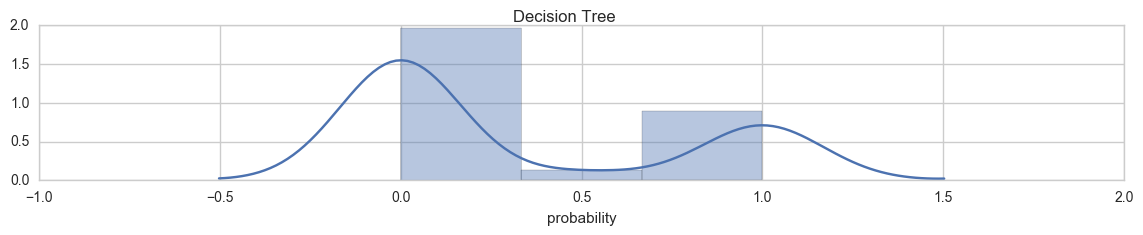

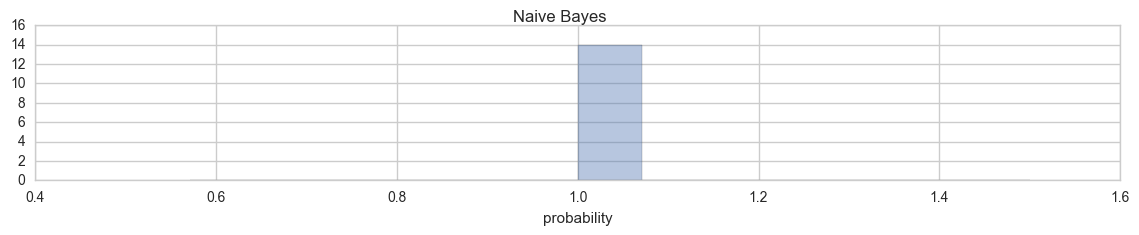

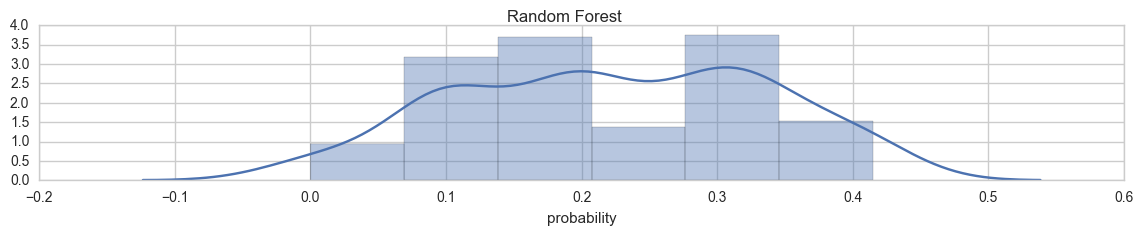

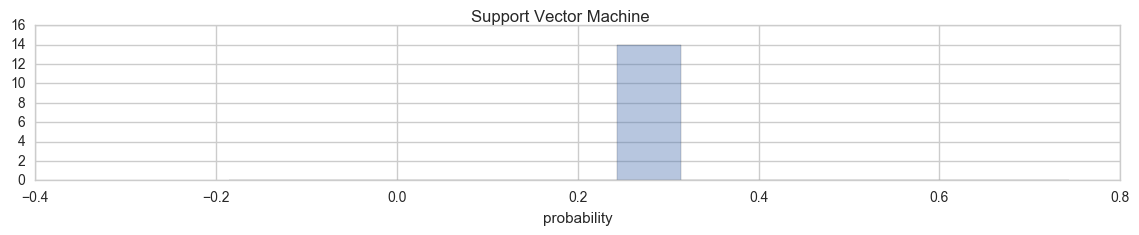

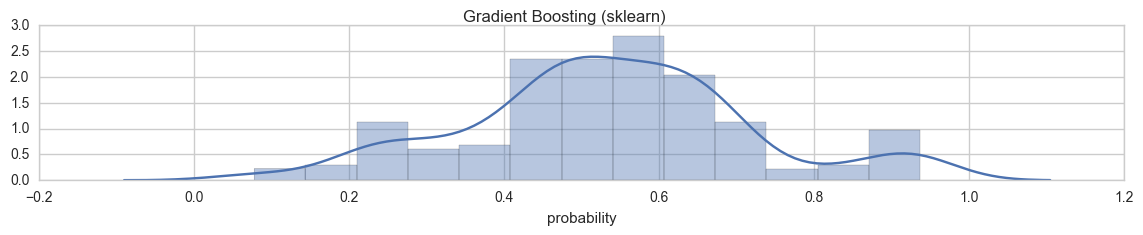

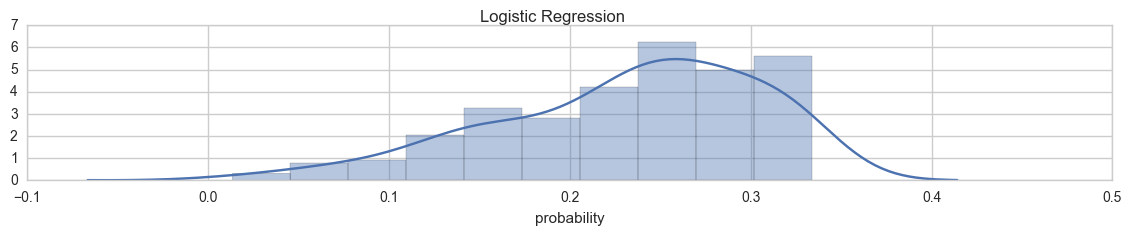

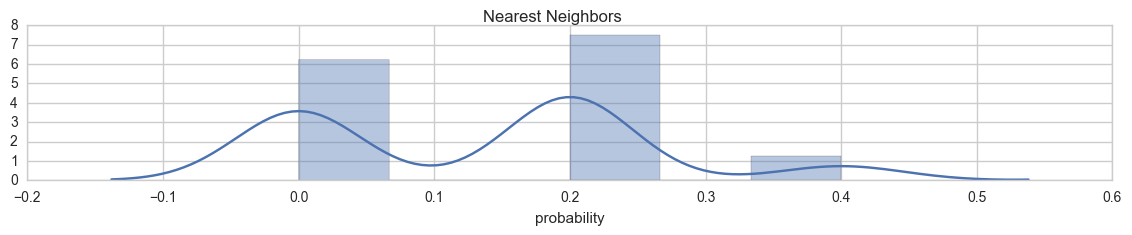

In [15]:
for (modelName, response) in responses.items():
    plt.figure(figsize=(14,2))
    seaborn.distplot(response["probability"])
    plt.suptitle(modelName)

### Cross-Validation

In [16]:
from sklearn import model_selection, metrics

In [17]:
metric = metrics.log_loss

In [18]:
def crossValidateModels(modelTypes, trainingData, responseVariable):
    XTrain = trainingData.ix[:, trainingData.columns.difference([responseVariable])]
    yTrain = trainingData.ix[:, responseVariable]
    modelScores = {}
    for (modelName, (ModelClass, params)) in modelTypes.items():
        model = ModelClass(**params)
        print("cross-validating ", modelName)
        scores = model_selection.cross_val_score(scoring=metrics.make_scorer(metric, greater_is_better=False),
                                                cv=10,
                                                estimator=model,
                                                X=XTrain,
                                                y=yTrain)
        modelScores[modelName] = scores.mean()
    cvScoreData = pandas.DataFrame(list(modelScores.items()), columns=["model", "score"]).sort_values(by="score")
    cvScoreData.index = range(1,len(cvScoreData) + 1)
    return cvScoreData

In [19]:
cvScores = crossValidateModels(modelTypes, trainingData, responseVariable="Made Donation in March 2007")

cross-validating  Decision Tree
cross-validating  Naive Bayes
cross-validating  Random Forest
cross-validating  Support Vector Machine
cross-validating  Gradient Boosting (sklearn)
cross-validating  Logistic Regression
cross-validating  Nearest Neighbors


In [20]:
cvScores.sort_index(ascending=False)

,model,score
7,Logistic Regression,-8.451819
6,Naive Bayes,-8.694288
5,Support Vector Machine,-9.647086
4,Gradient Boosting (sklearn),-9.995923
3,Random Forest,-10.595686
2,Nearest Neighbors,-11.312423
1,Decision Tree,-13.362669


In [21]:
def plotScores(scores, title):
    plt.figure(figsize=(14,2))
    plt.bar(scores.index, scores["score"], color="darkred")
    plt.xticks(scores.index, scores["model"], rotation=25)
    plt.suptitle(title)


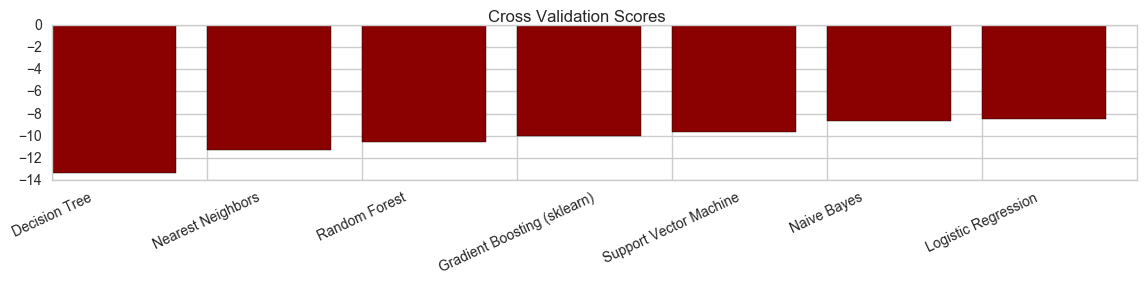

In [22]:
plotScores(cvScores, title="Cross Validation Scores")

## Preprocessing Hypothesis Checks

###  Deleting perfectly correlated column "Total Volume..."

In [23]:
cvScoresNonredundant = crossValidateModels(modelTypes, trainingData[trainingData.columns.drop("Total Volume Donated (c.c.)")],
                               responseVariable="Made Donation in March 2007")
cvScoresNonredundant.sort_index(ascending=False)

cross-validating  Decision Tree
cross-validating  Naive Bayes
cross-validating  Random Forest
cross-validating  Support Vector Machine
cross-validating  Gradient Boosting (sklearn)
cross-validating  Logistic Regression
cross-validating  Nearest Neighbors


,model,score
7,Naive Bayes,-8.451823
6,Logistic Regression,-8.511370
5,Support Vector Machine,-9.647093
4,Gradient Boosting (sklearn),-9.995923
3,Nearest Neighbors,-10.531885
2,Random Forest,-10.716909
1,Decision Tree,-13.541318


In [24]:
def compareScores(scoresA, scoresB):
    comparison = scoresA.copy()
    comparison["score"] = scoresA["score"] - scoresB["score"]
    return comparison

In [25]:
compareScores(cvScores, cvScoresNonredundant)

,model,score
1,Decision Tree,0.178649
2,Nearest Neighbors,-0.595514
3,Random Forest,-0.063800
4,Gradient Boosting (sklearn),0.000000
5,Support Vector Machine,0.000007
6,Naive Bayes,-0.182918
7,Logistic Regression,0.000004


### Sorting Input Data by ID

In [26]:
cvScoresSorted = crossValidateModels(modelTypes, trainingData.sort_index(),
                               responseVariable="Made Donation in March 2007")
cvScoresSorted.sort_index(ascending=False)

cross-validating  Decision Tree
cross-validating  Naive Bayes
cross-validating  Random Forest
cross-validating  Support Vector Machine
cross-validating  Gradient Boosting (sklearn)
cross-validating  Logistic Regression
cross-validating  Nearest Neighbors


,model,score
7,Gradient Boosting (sklearn),-7.915897
6,Logistic Regression,-8.147681
5,Random Forest,-8.402947
4,Nearest Neighbors,-8.453985
3,Support Vector Machine,-8.456068
2,Naive Bayes,-8.743204
1,Decision Tree,-9.483364


In [27]:
compareScores(cvScores, cvScoresSorted)

,model,score
1,Decision Tree,-3.879305
2,Nearest Neighbors,-2.569219
3,Random Forest,-2.139618
4,Gradient Boosting (sklearn),-1.541938
5,Support Vector Machine,-1.244139
6,Naive Bayes,-0.546607
7,Logistic Regression,-0.535923


## Preprocessing

**delete column "Volume"**

In [28]:
trainingData = trainingData[trainingData.columns.drop("Total Volume Donated (c.c.)")]

In [29]:
testData = testData[testData.columns.drop("Total Volume Donated (c.c.)")]

**sort by id**

In [30]:
trainingData = trainingData.sort_index()

In [31]:
#testData = testData.sort_index()

## Hypertuning

In [32]:
modelTypes.keys()

dict_keys(['Decision Tree', 'Naive Bayes', 'Random Forest', 'Support Vector Machine', 'Gradient Boosting (sklearn)', 'Logistic Regression', 'Nearest Neighbors'])

In [33]:
hyperParameterSpaces = {
    "Decision Tree" : {
        "max_features": ["auto", None],
        "max_depth": [2, 4, 6, 8, None]
    },
    "Support Vector Machine" : {
        "C" : numpy.logspace(-2, 10, 4),
        "gamma" : numpy.logspace(-9, 3, 4)
    },
    "Logistic Regression" : {
        "penalty": ["l1", "l2"],
        "C":  numpy.logspace(-2, 10, 4),
    },
    "Gradient Boosting (sklearn)" : {},
    "Nearest Neighbors" : {
       "n_neighbors" : [1,2,4,6,8]
    },
    "Random Forest" : {
        "max_features": ["auto", None],
        "max_depth": [2, 4, 6, 8, None],
        "n_estimators": [10, 20, 40]
    },
    "Naive Bayes" : {},
}

In [34]:
def hypertuneAndCrossValidateModels(modelTypes, trainingData, responseVariable):
    hypertunedModels = {}
    modelScores = {}
    XTrain = trainingData.ix[:, trainingData.columns.difference([responseVariable])]
    yTrain = trainingData.ix[:, responseVariable]
    cvScores = []
    for (modelName, (ModelClass, params)) in modelTypes.items():
        hypertunedModels[modelName] = model_selection.GridSearchCV(ModelClass(**params), 
                                              param_grid=hyperParameterSpaces[modelName],
                                              scoring=metrics.make_scorer(metric, greater_is_better=False))
        print("hypertuning {0}".format(modelName))
        %time hypertunedModels[modelName].fit(XTrain, yTrain)
        print("best hyperparameters: ", hypertunedModels[modelName].best_params_, " best score: ", hypertunedModels[modelName].best_score_)
        print()
        cvScores.append((modelName, hypertunedModels[modelName].best_score_))
    cvScoreData = pandas.DataFrame(cvScores, columns=["model", "score"]).sort_values(by="score")
    cvScoreData.index = range(1,len(cvScoreData) + 1)
    return (cvScoreData, hypertunedModels)

In [35]:
(hypertunedScores, hypertunedModels) = hypertuneAndCrossValidateModels(modelTypes, trainingData, responseVariable="Made Donation in March 2007")

hypertuning Decision Tree
CPU times: user 171 ms, sys: 2.97 ms, total: 174 ms
Wall time: 182 ms
best hyperparameters:  {'max_features': None, 'max_depth': 4}  best score:  -8.2150047757

hypertuning Naive Bayes
CPU times: user 13.7 ms, sys: 65 µs, total: 13.8 ms
Wall time: 13.8 ms
best hyperparameters:  {}  best score:  -8.21498117647

hypertuning Random Forest
CPU times: user 3.62 s, sys: 18 ms, total: 3.64 s
Wall time: 3.69 s
best hyperparameters:  {'max_features': None, 'n_estimators': 20, 'max_depth': 6}  best score:  -7.43548933344

hypertuning Support Vector Machine
CPU times: user 2min 15s, sys: 712 ms, total: 2min 16s
Wall time: 2min 18s
best hyperparameters:  {'C': 10000000000.0, 'gamma': 1.0000000000000001e-05}  best score:  -7.43546989878

hypertuning Gradient Boosting (sklearn)
CPU times: user 219 ms, sys: 2.52 ms, total: 222 ms
Wall time: 221 ms
best hyperparameters:  {}  best score:  -8.15504162224

hypertuning Logistic Regression
CPU times: user 113 ms, sys: 843 µs, tota

In [36]:
compareScores(cvScores, hypertunedScores)

,model,score
1,Decision Tree,-5.147664
2,Nearest Neighbors,-3.097442
3,Random Forest,-2.440644
4,Gradient Boosting (sklearn),-1.840916
5,Support Vector Machine,-1.731925
6,Naive Bayes,-1.258799
7,Logistic Regression,-1.016349


In [37]:
hypertunedScores

,model,score
1,Decision Tree,-8.215005
2,Naive Bayes,-8.214981
3,Gradient Boosting (sklearn),-8.155042
4,Logistic Regression,-8.155007
5,Nearest Neighbors,-7.915161
6,Random Forest,-7.435489
7,Support Vector Machine,-7.435470


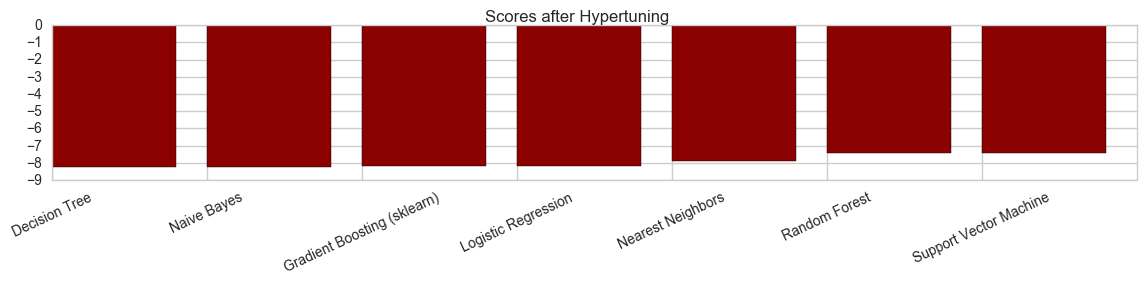

In [38]:
plotScores(hypertunedScores, "Scores after Hypertuning")

# Actual Training & Prediction

split off column with response variable

In [39]:
responseVariable = "Made Donation in March 2007"

In [40]:
XTrain = trainingData.ix[:, trainingData.columns.difference([responseVariable])]
yTrain = trainingData.ix[:, responseVariable]

In [41]:
model = svm.SVC(**{'C': 10000000000.0, 'gamma': 1.0000000000000001e-05, 'probability' : True})
model.fit(XTrain, yTrain)
response = pandas.Series(model.predict_proba(testData)[:,1], index=testData.index)

# Submission

In [42]:
sampleSubmission = pandas.read_csv("BloodDonationSubmissionFormat.csv", index_col=0)

In [43]:
sampleSubmission.head()

,Made Donation in March 2007
659,0.5
276,0.5
263,0.5
303,0.5
83,0.5


In [44]:
testData.head()

,Months since Last Donation,Number of Donations,Months since First Donation
659,2,12,52
276,21,7,38
263,4,1,4
303,11,11,38
83,4,12,34


In [45]:
response.head()

659    0.000013
276    0.038300
263    0.228875
303    0.003297
83     0.002001
dtype: float64

In [46]:
submission = pandas.DataFrame({"Made Donation in March 2007" : response})
submission.head()

,Made Donation in March 2007
659,0.000013
276,0.038300
263,0.228875
303,0.003297
83,0.002001


/usr/local/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


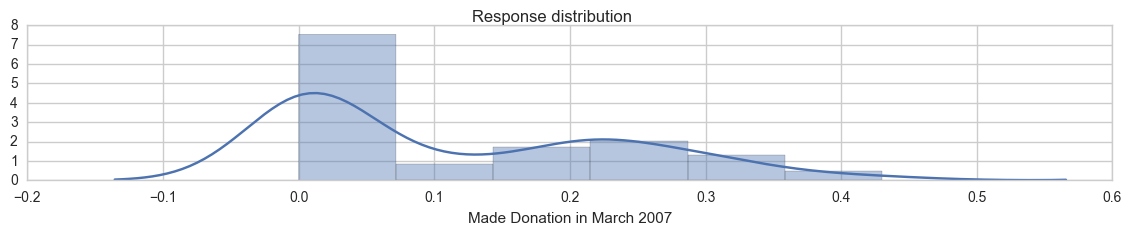

In [47]:
plt.figure(figsize=(14,2))
seaborn.distplot(submission[responseVariable])
plt.suptitle("Response distribution")

In [48]:
submission.to_csv("submission.csv")